In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import ipdb

## Configurations

In [2]:
#TODO: There are many configuration parameters here. It is important to understand the effect of all.
d = 2

#This variance will determine the size of sensitivity parameter.
coeff_var = 1
Sigma_x = np.eye(d)
sigma_y = 10
stage_two_iter = 1000
num_test = 10000

In [3]:
beta_p1 = np.random.normal(size = d)
beta_p2 = np.random.normal(size = d)


mu_p1 = np.random.normal(scale = coeff_var, size = d)
mu_p2 = np.random.normal(scale = coeff_var, size = d)
gamma_p1 = np.random.normal(scale = coeff_var, size = d)
gamma_p2 = np.random.normal(scale = coeff_var, size = d)

## Helper functions

In [4]:
"""
TODO:
Fill in these missing functions
Pass the arguments around correctly
Debug and make plot of performative risk
Try for d=2 and make a trajectory plot too
"""

def obtain_data(n, d, mu_p1, gamma_p1, mu_p2, gamma_p2, cov_x, sigma_y):
    theta_p1_lst = []
    z_p1_lst, z_p2_lst = [], []
    theta_p2_lst = []
    
    for i in np.arange(2*n):
        #Both players play random actions to gather information
        theta_p1_i, theta_p2_i = np.random.normal(size = d), np.random.normal(size = d)
        theta_p1_lst.append(theta_p1_i)
        theta_p2_lst.append(theta_p2_i)

        #Both players 
        z_p1_i = sample_from_distribution(cov_x, sigma_y, beta_p1, mu_p1, gamma_p1, theta_p1_i, theta_p2_i)
        z_p2_i = sample_from_distribution(cov_x, sigma_y, beta_p2, mu_p2, gamma_p2, theta_p1_i, theta_p2_i)
        z_p1_lst.append(z_p1_i)
        z_p2_lst.append(z_p2_i)
    
    return np.array(z_p1_lst), np.array(z_p2_lst), np.array(theta_p1_lst), np.array(theta_p2_lst)


def sample_from_distribution(cov_x, sigma_y, beta, mu, gamma, theta_p1, theta_p2):
    x = np.random.multivariate_normal(np.zeros(len(cov_x)), cov_x)
    U_y = np.random.normal(0, sigma_y)
    y = beta.T @ x + mu.T @ theta_p1 + gamma.T @ theta_p2 + U_y
    return (x, y)
    
def solve_distribution_params(z_lst, theta_p1_lst, theta_p2_lst):
    y = [e[1] for e in z_lst]
    A = np.hstack((theta_p1_lst, theta_p2_lst))
    mu_tilde = np.linalg.inv(A.T @ A) @ A.T @ y
    
    num_each = int(len(mu_tilde)/2)
    mu_hat = mu_tilde[:num_each]
    gamma_hat = mu_tilde[num_each:]
    return mu_hat, gamma_hat

def find_qs(mu_hat, gamma_hat, z_lst, theta_p1_lst, theta_p2_lst):
    y_lst = [e[1] for e in z_lst]
    q_lst = []
    for (idx, y) in enumerate(y_lst):
        theta_p1 = theta_p1_lst[idx]
        theta_p2 = theta_p2_lst[idx]
        q = y - np.dot(mu_hat, theta_p1) - np.dot(gamma_hat, theta_p2)
        q_lst.append(q)
    return np.array(q_lst)
        
    
def solve_theta(x_lst, q, mu_hat, gamma_hat, theta_other):
    y_mod = q + np.dot(gamma_hat, theta_other)*np.ones(len(q))
    x_arr = np.array(x_lst)
    #TODO: Ensure that this subtracts from each row like I expect
    A = x_arr - mu_hat
    theta = np.linalg.inv(A.T @ A) @ A.T @ y_mod
    #ipdb.set_trace()
    return theta


def run_first_stage(z_p1_lst, z_p2_lst, theta_p1_lst, theta_p2_lst):
    mu_hat_p1, gamma_hat_p1 = solve_distribution_params(z_p1_lst, theta_p1_lst, theta_p2_lst)
    mu_hat_p2, gamma_hat_p2 = solve_distribution_params(z_p2_lst, theta_p1_lst, theta_p2_lst)
    return mu_hat_p1, gamma_hat_p1, mu_hat_p2, gamma_hat_p2

def run_second_stage(x_p1_lst, q_p1, x_p2_lst, q_p2, mu_hat_p1, 
                        gamma_hat_p1, mu_hat_p2, gamma_hat_p2, num_iter):
    
    theta_p1_init, theta_p2_init = np.random.normal(size = d), np.random.normal(size = d)
    theta_p1_lst, theta_p2_lst = [theta_p1_init], [theta_p2_init]
    
    for k in range(num_iter):
        #Solve theta for player 1
        theta_p2_prev = theta_p2_lst[-1]
        theta_p1_k= solve_theta(x_p1_lst, q_p1, mu_hat_p1, gamma_hat_p1, theta_p2_prev)
        
        
        #Solve theta for player 2
        theta_p1_prev = theta_p1_lst[-1]
        theta_p2_k= solve_theta(x_p2_lst, q_p2, mu_hat_p2, gamma_hat_p2, theta_p1_prev)
        
        theta_p1_lst.append(theta_p1_k)
        theta_p2_lst.append(theta_p2_k)
    
    return theta_p1_lst, theta_p2_lst

def evaluate_test_performative_risk(beta, mu, gamma, theta_p1, theta_p2, cov_x, sigma_y, num_test):
    test_set = [sample_from_distribution(cov_x, sigma_y, beta, mu, gamma, theta_p1, theta_p2) for e in range(num_test)]
    x_test = np.array([e[0] for e in test_set])
    y_test = [e[1] for e in test_set]
    y_pred = x_test @ theta_p1
    mse = np.linalg.norm(y_test - y_pred)**2
    mse_avg = mse/len(y_test)
    return mse_avg

def solve_PO_given_theta():
    pass

#TODO: cov_x and sigma_y could also be different for the two players. Change this later.
def run_game(n, d, mu_p1, gamma_p1, mu_p2, gamma_p2, num_iter_stage_two, num_test, cov_x, sigma_y, beta_p1, beta_p2): 
    
    #Obtain and split up the data for both stages
    z_p1_lst, z_p2_lst, theta_p1_lst, theta_p2_lst = obtain_data(n, d, mu_p1, gamma_p1, 
                                                                 mu_p2, gamma_p2, cov_x, sigma_y)
    
    num_first_stage = n
    z_p1_lst_sliced = (z_p1_lst[:num_first_stage], z_p1_lst[num_first_stage:])
    z_p2_lst_sliced = (z_p2_lst[:num_first_stage], z_p2_lst[num_first_stage:])

    theta_p1_lst_sliced = (theta_p1_lst[:num_first_stage], theta_p1_lst[num_first_stage:])
    theta_p2_lst_sliced = (theta_p2_lst[:num_first_stage], theta_p2_lst[num_first_stage:])
    
    #Stage 1
    mu_hat_p1, gamma_hat_p1, mu_hat_p2, gamma_hat_p2 = run_first_stage(z_p1_lst_sliced[0], z_p2_lst_sliced[0], 
                                                                       theta_p1_lst_sliced[0], theta_p2_lst_sliced[0])
    
    print("-------------")
    print("n="+ str(n))
    print("Player 1:")
    print(mu_p1)
    print(mu_hat_p1)
    print("Player 2:")
    print(mu_p2)
    print(mu_hat_p2)
    print("-------------")
    
    #Obtain qs for stage 2
    q_p1_lst = find_qs(mu_hat_p1, gamma_hat_p1, z_p1_lst_sliced[1], theta_p1_lst_sliced[1], theta_p2_lst_sliced[1])
    q_p2_lst = find_qs(mu_hat_p2, gamma_hat_p2, z_p2_lst_sliced[1], theta_p1_lst_sliced[1], theta_p2_lst_sliced[1])
    
    #Stage 2
    x_lst_p1 = [e[0] for e in z_p1_lst_sliced[1]]
    x_lst_p2 = [e[0] for e in z_p2_lst_sliced[1]]
    
    theta_p1_final_lst, theta_p2_final_lst = run_second_stage(x_lst_p1, q_p1_lst, x_lst_p2, q_p2_lst, 
                                                  mu_hat_p1, gamma_hat_p1, mu_hat_p2, gamma_hat_p2, num_iter_stage_two)
    
    perf_risk_p1 = evaluate_test_performative_risk(beta_p1, mu_p1, gamma_p1, theta_p1_final_lst[-1], 
                                                   theta_p2_final_lst[-1], cov_x, sigma_y, num_test)
    
    
    perf_risk_p2 = evaluate_test_performative_risk(beta_p2, mu_p2, gamma_p2, theta_p1_final_lst[-1], 
                                                   theta_p2_final_lst[-1], cov_x, sigma_y, num_test)
    
    theta_p1, theta_p2 = theta_p1_final_lst[-1], theta_p2_final_lst[-1]
    
    return theta_p1, theta_p2, perf_risk_p1, perf_risk_p2

In [5]:
n_lst = [1, 2, 3, 5, 10, 100, 1000, 10000]
pr_p1_lst = []
pr_p2_lst = []
theta_p1_lst = []
theta_p2_lst = []

for n_r in n_lst:
    tp1, tp2, pr_p1, pr_p2 = run_game(n_r, d, mu_p1, gamma_p1, mu_p2, gamma_p2, stage_two_iter, num_test, 
                            Sigma_x, sigma_y, beta_p1, beta_p2)
    
    theta_p1_lst.append(tp1)
    theta_p2_lst.append(tp2)
    pr_p1_lst.append(pr_p1)
    pr_p2_lst.append(pr_p2)

-------------
n=1
Player 1:
[-1.69191314  0.74440442]
[-18.73328827 449.59891858]
Player 2:
[-0.80146634 -0.89855495]
[  19.98815536 -479.71572873]
-------------


/Users/adhyyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in matmul


-------------
n=2
Player 1:
[-1.69191314  0.74440442]
[-148.53486312   -1.21980632]
Player 2:
[-0.80146634 -0.89855495]
[194.16039332   5.27755825]
-------------
-------------
n=3
Player 1:
[-1.69191314  0.74440442]
[-2.09998462  0.0741787 ]
Player 2:
[-0.80146634 -0.89855495]
[-5.94513025  2.6178749 ]
-------------
-------------
n=5
Player 1:
[-1.69191314  0.74440442]
[33.96283215 47.02478533]
Player 2:
[-0.80146634 -0.89855495]
[33.56305395 25.5483116 ]
-------------
-------------
n=10
Player 1:
[-1.69191314  0.74440442]
[-6.09452549  4.12628902]
Player 2:
[-0.80146634 -0.89855495]
[-0.1492289  -6.89808682]
-------------
-------------
n=100
Player 1:
[-1.69191314  0.74440442]
[-2.47952915  1.52005453]
Player 2:
[-0.80146634 -0.89855495]
[-0.30042997 -0.495153  ]
-------------
-------------
n=1000
Player 1:
[-1.69191314  0.74440442]
[-0.80088765  0.58028123]
Player 2:
[-0.80146634 -0.89855495]
[-0.89416897 -0.92223452]
-------------
-------------
n=10000
Player 1:
[-1.69191314  0.7444

In [6]:
# get the Performative Optima
def solve_theta_PO(mu_1,mu_2,gamma_1,gamma_2, beta_1,beta_2,Sigma_x):
    mu_Sig_1 = np.outer(mu_1, mu_1) - Sigma_x
    mu_Sig_2 = np.outer(mu_2, mu_2) - Sigma_x
    mu_gamma_1 = np.outer(mu_1, gamma_1) 
    mu_gamma_2 = np.outer(mu_2, gamma_2) 
    A_1 = np.linalg.inv(mu_Sig_2 @ np.linalg.inv(mu_gamma_1) @ mu_Sig_1 - mu_gamma_2)
    A_2 = np.linalg.inv(mu_Sig_1 @ np.linalg.inv(mu_gamma_2) @ mu_Sig_2 - mu_gamma_1)
    
    B_1 = mu_Sig_2 @ np.linalg.inv(mu_gamma_1) @ Sigma_x @ beta_1 - Sigma_x @ beta_2
    B_2 = mu_Sig_1 @ np.linalg.inv(mu_gamma_2) @ Sigma_x @ beta_2 - Sigma_x @ beta_1
    
    
    theta_PO_1 = A_1 @ B_1
    theta_PO_2 = A_2 @ B_2
    return theta_PO_1, theta_PO_2


theta_PO_p1, theta_PO_p2 = solve_theta_PO(mu_p1,mu_p2,gamma_p1,gamma_p2, beta_p1, beta_p2, Sigma_x)

pr_PO_p1 = evaluate_test_performative_risk(beta_p1, mu_p1, gamma_p1, theta_PO_p1, 
                                                   theta_PO_p2, Sigma_x, sigma_y, num_test)
pr_PO_p2 = evaluate_test_performative_risk(beta_p2, mu_p2, gamma_p2, theta_PO_p1, 
                                                   theta_PO_p2, Sigma_x, sigma_y, num_test)
    

In [7]:
print(pr_PO_p1, pr_PO_p2)

103.69274092224587 101.93017112698814


In [8]:
theta_p1_lst = np.array(theta_p1_lst)
theta_p2_lst = np.array(theta_p2_lst)

In [9]:
theta_p1_lst.shape

(8, 2)

## Create plots

In [10]:
import seaborn as sns
sns.set_style('darkgrid')

Text(0.5, 1.0, 'Params learned after stage 2 with n points')

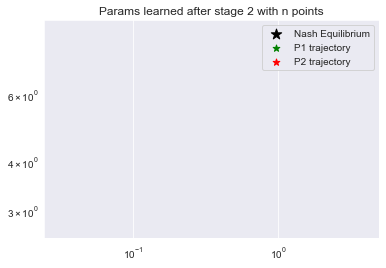

In [11]:
x = [theta_PO_p1[0], theta_PO_p2[0]]
y = [theta_PO_p1[1], theta_PO_p2[1]]
plt.scatter(x,y, label = 'Nash Equilibrium', marker = '*', color = 'k', s = 120)

x2 = theta_p1_lst[:, 0]
y2 = theta_p1_lst[:, 1]
plt.scatter(x2,y2, label = 'P1 trajectory', marker = '*', color = 'g', s = 50)

x3 = theta_p2_lst[:, 0]
y3 = theta_p2_lst[:, 1]
plt.scatter(x3,y3, label = 'P2 trajectory', marker = '*', color = 'r', s = 50)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title("Params learned after stage 2 with n points")

In [12]:
theta_p2_lst

array([[         nan,          nan],
       [  2.04640342, -42.50328734],
       [  3.86759364, -13.70282171],
       [ -3.21279889,  -5.74718544],
       [  2.73231661,  -1.75660167],
       [ -0.46930245,   2.70509644],
       [  0.34039875,   0.61423865],
       [ -0.2125418 ,   0.65077429]])

In [15]:
theta_PO_p2

array([0., 0.])

Text(0.5, 1.0, 'Convergence in performative risks')

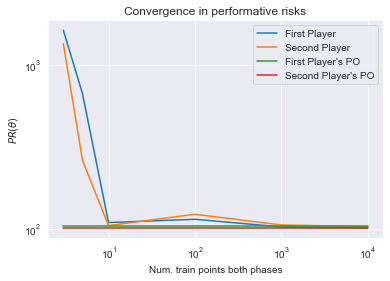

In [14]:
plt.plot(n_lst[2:], pr_p1_lst[2:], label = 'First Player')
plt.plot(n_lst[2:], pr_p2_lst[2:], label = 'Second Player')
plt.plot(n_lst[2:], pr_PO_p1* np.ones( (len(n_lst[2:]), 1)) , label = 'First Player\'s PO')
plt.plot(n_lst[2:], pr_PO_p2* np.ones( (len(n_lst[2:]), 1)) , label = 'Second Player\'s PO')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.xlabel("Num. train points both phases")
plt.ylabel(r"$PR(\theta)$")
plt.title("Convergence in performative risks")
#plt.savefig("/Users/adhyyan/Desktop/multiplayer_pp_simulation.pdf", format = 'pdf')